<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Настройка-среды" data-toc-modified-id="Настройка-среды-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Настройка среды</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Настройка среды

In [ ]:
!pip install -qU pip
!pip install -qU seaborn pandas statsmodels lightgbm scikit-learn

In [1]:
from lightgbm.sklearn import LGBMRegressor

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

In [5]:
sns.set_style('darkgrid')

## Подготовка данных

In [6]:
# Set 'Datetime' as index of type datetime64 during data loading
taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])
# Sort data by index
taxi = taxi.sort_index()
# Resample data for 1 hour and agregate 'num_orders'
taxi = taxi.resample('1H').sum()
taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [8]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


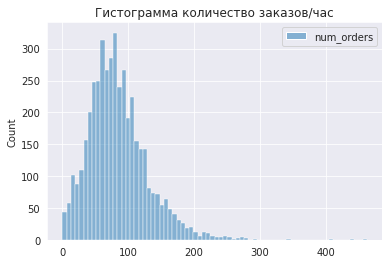

In [9]:
ax = sns.histplot(taxi)
_ = ax.set_title("Гистограмма количество заказов/час")

### Вывод

- Данные сгруппированы по суммарному значению в часовом интервале 
- Распределение числа заказов такси скошено вправо
- Есть нулевые значения. Что значит, бывает, в течении часа заказов нет
- Есть большие значения хвоста справа. Что означает аврал заказов, что также "бывает"
- Пропусков нет

## Анализ

In [10]:
def make_features(
    _df: pd.DataFrame, *,
    target_name: str, 
    max_lag: int, 
    window: int,
) -> pd.DataFrame:
    
    """Feature generation for time series. Make features:
        - year
        - month
        - day
        - dayofweek
        - lag_{i} wich count defined by `max_lags` parameter
        - rolling_mean
        - trend
        - seasonal
        - resid
        
        Parameters
        ----------
        target_name : str
            Target column name.
        max_lag : int
            Max shifts.
        window : int
            Rolling mean window size.
            
        Returns
        -------
        Panas DataFrame object."""
    
    df = _df.copy()
    
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    lags = []
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df[target_name].shift(lag)

    df['rolling_mean'] = df[target_name].shift().rolling(window).mean()
    
    decomposed = seasonal_decompose(df[target_name])
    df['trend'] = decomposed.trend.shift()
    df['seasonal'] = decomposed.seasonal.shift()
    df['resid'] = decomposed.resid.shift()
    
    return df

In [11]:
lags = 24
window_size = 13
taxi = make_features(taxi, target_name='num_orders', max_lag=lags, window=window_size)

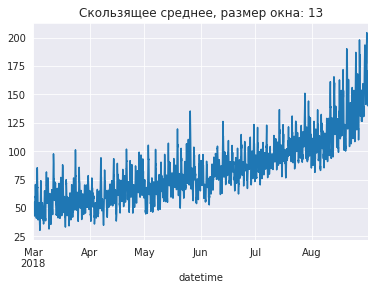

In [12]:
ax = taxi['rolling_mean'].plot()
_ = ax.set_title("Скользящее среднее, размер окна: {}".format(window_size))

Созерцая значения скользящего среднего, можно заметить не крутой, но уверенный uptrend.

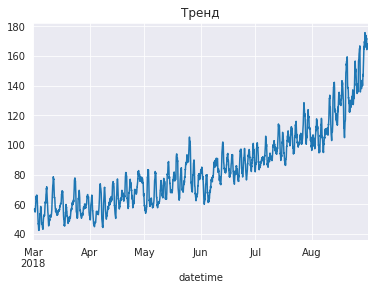

In [13]:
ax = taxi['trend'].plot()
_ = ax.set_title("Тренд")

Предыдущий вывод подтверждается тренд-сотавляющей декомпозиции значений целевого признака. И себя проверил: скользящее среднее похоже на этот график.

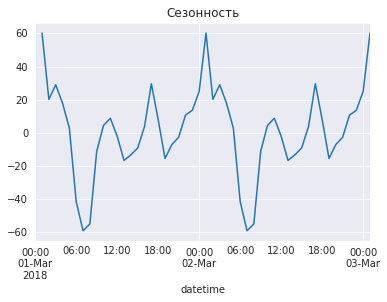

In [14]:
ax = taxi['seasonal'][:50].plot()
_ = ax.set_title("Сезонность")

По сезонной составляющей можно сделать вывод **о наличии периода** с 6 утра до 6 утра следующего дня в целевых значениях; **с тремя пиками** в 10:00, 16:00 и 12 часов ночи. Можно предположить, что утром люди едут на работку, вечером с работы и в двенадцать, уже нарядные, еще раз заказывают такси.

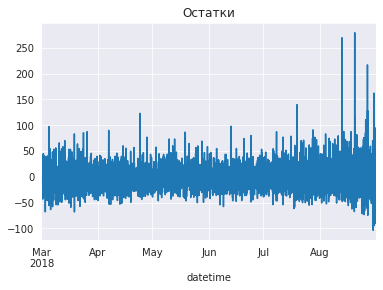

In [15]:
ax = taxi['resid'].plot()
_ = ax.set_title("Остатки")

Остатки выглядят с довольно постоянным средним и дисперсией с несколькими отдельными пиками в сентябре (на которые можно смотреть как выбросы).

In [16]:
X = taxi.drop(columns=['num_orders', 'rolling_mean'])
y = taxi['num_orders']

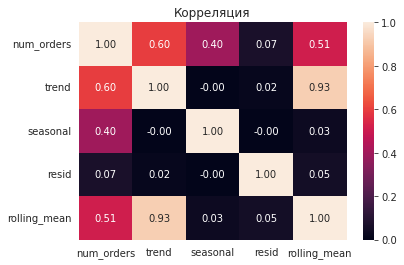

In [17]:
ax = sns.heatmap(
    taxi[["num_orders", "trend", "seasonal", "resid", "rolling_mean"]].corr(),
    fmt='.2f',
    annot=True
)
_ = ax.set_title("Корреляция")

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X.fillna(0), y, test_size=.1, shuffle=False)

### Вывод

- Временной ряд количества заказов такси в час нестационарный с верхним трендом и сезонностью в период на 24 часа с 6:00 по 6:00.
- Добавлены признаки: год, месяц, день месяца, день недели, временные сдвиги, скользящее среднее, а также признаки декомпозиции: тренд, сезонность и остатки.
- Среди полученных данных есть сильно скоррелированные признаки.

## Обучение

Попробуем обучить три модели: линейную, случайный лес и бустинг деревьев

In [19]:
rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

ElasticNet

RMSE на обучающей выборке: 23.57
RMSE на тестовой выборке: 45.17

CPU times: user 260 ms, sys: 484 ms, total: 744 ms
Wall time: 101 ms


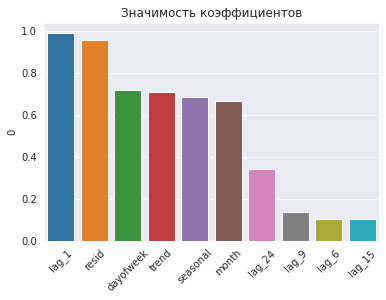

In [20]:
%%time

# Define linear model
linear_model = ElasticNet(random_state=12345)
    
# Fit model
linear_model.fit(X_train, y_train)

# Format linear model coefficients to dataframe
df = pd.DataFrame(
    [np.abs(linear_model.coef_)], 
    columns=X_train.columns
).sort_values(by=0, axis=1, ascending=False)

# Print RMSE score
linear_rmse_train = abs(rmse(linear_model, X_train, y_train))
linear_rmse_test = abs(rmse(linear_model, X_test, y_test))
print("""\
ElasticNet

RMSE на обучающей выборке: {:.2f}
RMSE на тестовой выборке: {:.2f}
""".format(linear_rmse_train, linear_rmse_test))

# Draw coefs barplot
bound = 10
rotation = 45

ax = sns.barplot(x=df.columns[:bound], y=df.iloc[0, :bound])
ax.set_xticklabels(ax.get_xticklabels(), rotation = rotation)
_ = ax.set_title("Значимость коэффициентов")

In [21]:
%%time

# Define wood model with hyperparameters tuning
wood_model = GridSearchCV(
    RandomForestRegressor(criterion='squared_error', random_state=12345),
    param_grid={
        "n_estimators": [25, 50, 100],
        "min_samples_leaf": [1, 2, 4],
        "min_samples_split": [2, 5, 10],
    },
    cv=TimeSeriesSplit(),
    n_jobs=4
)

# Fit wood model
wood_model.fit(X_train, y_train)

# Print RMSE score
wood_rmse_train = abs(rmse(wood_model, X_train, y_train))
wood_rmse_test = abs(rmse(wood_model, X_test, y_test))
print("""\
RandomForestRegressor

RMSE на обучающей выборке: {:.2f}
RMSE на тестовой выборке: {:.2f}
""".format(wood_rmse_train, wood_rmse_test))

print("Лучшие параметры модели:")
for name, value in wood_model.best_params_.items():
    print("\t{}: {}".format(name, value))
print()

RandomForestRegressor

RMSE на обучающей выборке: 9.65
RMSE на тестовой выборке: 42.99

Лучшие параметры модели:
	min_samples_leaf: 2
	min_samples_split: 5
	n_estimators: 100

CPU times: user 3.69 s, sys: 72.5 ms, total: 3.76 s
Wall time: 36.9 s


LightGBM

RMSE на обучающей выборке: 6.31
RMSE на тестовой выборке: 43.93

Лучшие параметры модели:
	n_estimators: 250

CPU times: user 1.29 s, sys: 25.1 ms, total: 1.31 s
Wall time: 2.2 s


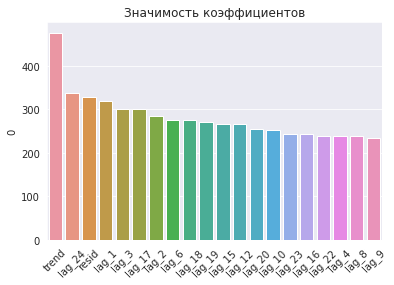

In [22]:
%%time

# Define wood model with hyperparameters tuning
lgbm_model = GridSearchCV(
    LGBMRegressor(random_state=12345),
    param_grid={
        "n_estimators": [250, 500, 1000],
#         "min_data_in_leaf": [100, 300],
#         "num_leaves": [20, 40, 60]
    },
    cv=TimeSeriesSplit(),
    n_jobs=4
)

# Fit lgbm model
lgbm_model.fit(X_train, y_train)

# Print RMSE score
lgbm_rmse_train = abs(rmse(lgbm_model, X_train, y_train))
lgbm_rmse_test = abs(rmse(lgbm_model, X_test, y_test))
print("""\
LightGBM

RMSE на обучающей выборке: {:.2f}
RMSE на тестовой выборке: {:.2f}
""".format(lgbm_rmse_train, lgbm_rmse_test))

print("Лучшие параметры модели:")
for name, value in lgbm_model.best_params_.items():
    print("\t{}: {}".format(name, value))
print()

# Format lgbm model coefficients to dataframe
df = pd.DataFrame(
    [lgbm_model.best_estimator_.feature_importances_], 
    columns=X_train.columns
).sort_values(by=0, axis=1, ascending=False)

# Draw coefs barplot
bound = 20
rotation = 45

ax = sns.barplot(x=df.columns[:bound], y=df.iloc[0, :bound])
ax.set_xticklabels(ax.get_xticklabels(), rotation = rotation)
_ = ax.set_title("Значимость коэффициентов")

### Выводы

Модель|RMSE train|RMSE test
---|---|---
ElasticNet|23.57|45.17
RandomForest|9.65|42.99
LGBM|6.31|43.93

- Все обученные модели имеют допустимое значение метрики на тестовой выборке.
- Похоже все модели переобучились. Значения метрик для обучающей и тетовой выборок сильно отличаются.
- RandomForestRegressor обладатель наминьшего значения RMSE на тестовой выборке: 42.99.
- Наиболее значимые для ElasticNet признаки: 'lag_1', 'resid', 'dayofweek', 'trend', 'seasonal', 'month'
- Наиболее значимые для LGBM признаки: 'trend', 'lag_24', 'resid', 'lag_1' 

## Тестирование

In [23]:
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train, y_train)
dummy_regressor_rmse_train = abs(rmse(dummy_regressor, X_train, y_train))
dummy_regressor_rmse_test = abs(rmse(dummy_regressor, X_test, y_test))
print("""\
Модель прогноза среднего
RMSE на обучающей выборке: {:.2f}
RMSE на тестовой выборке: {:.2f}
""".format(dummy_regressor_rmse_train, dummy_regressor_rmse_test))

Модель прогноза среднего
RMSE на обучающей выборке: 38.67
RMSE на тестовой выборке: 84.74



In [24]:
lag = 1
y_previous = X_test['lag_{}'.format(lag)]
print()
print("""Прогнозирование по предыдущим значениям
Лаг номер: {}
RMSE на тестовой выборке: {:.2f}""".format(
        lag,
        abs(mean_squared_error(y_previous, y_test, squared=False))
    )
)


Прогнозирование по предыдущим значениям
Лаг номер: 1
RMSE на тестовой выборке: 58.86


## Выводы

Модель|RMSE train|RMSE test
---|---|---
ElasticNet|23.57|45.17
RandomForest|9.65|42.99
LGBM|6.31|43.93
Dummy Mean|38.67|84.74
Dummy Previos|-|58.86

- Временной ряд количества заказов такси в час нестационарный с верхним трендом и сезонностью в период на 24 часа с 6:00 по 6:00.
- Все обученные модели имеют допустимое значение метрики (ниже 48) на тестовой выборке.
- Значения метрик для обучающей и тетовой выборок сильно отличаются. Похоже все модели переобучились. 
- Лучшая модель: RandomForestRegressor обладатель наминьшего значения RMSE на тестовой выборке: 42.99.
- Значения метрик моделей на тестовой выборке ниже значений метрик обоих наивных моделей. 
- Наиболее значимые для ElasticNet признаки: 'lag_1', 'resid', 'dayofweek', 'trend', 'seasonal', 'month'
- Наиболее значимые для LGBM признаки: 'trend', 'lag_24', 'resid', 'lag_1'